<a href="https://colab.research.google.com/github/Tsanyu20/bachelor_thesis/blob/main/Copy_of_Preview_Copy_of_Social_Media_Analysis_101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Social Media Analysis 101

**Author**: [Yara Kyrychenko](https://www.sdmlab.psychol.cam.ac.uk/staff/yara-kyrychenko).



**Contents**:
1.   Scraping Telegram
2.   Text Analysis
3.   Statistics

Add your secrets in the panel to the left under the key sign.
  - You will need: `api_id`, `api_hash`, and `openai_key`.
  
Change runtime to GPU if you want to use GPU for open source zero shot classification.

**Don't forget to validate your LLM labels for real studies!!!**


In [7]:
!git clone https://github.com/Tsanyu20/bachelor_thesis.git

Cloning into 'bachelor_thesis'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 36 (delta 13), reused 32 (delta 12), pack-reused 0 (from 0)
Receiving objects: 100% (36/36), 973.16 KiB | 7.91 MiB/s, done.
Resolving deltas: 100% (13/13), done.


In [ ]:
!pip install -r /content/bachelor_thesis/requirements.txt

In [ ]:
import json
import re

with open('/content/bachelor_thesis/dntormozok.json', encoding='utf-8') as f:
  data = json.load(f)
li = []
for dic in data:
  if re.findall("2024-(10|11|12)", dic['date']):
    print(dic['date'])


## Extract content from json files and identify language used

In [3]:
import glob
import json

# Use this function to get all non-empty text/caption
def extract_text(json_files):
  all_content=[]
  for file in json_files:
        try:
            with open(file, 'r', encoding='utf-8') as f:
                data = json.load(f)
                for dic in data:
                  if dic['text']:
                    all_content.append(dic['text'])
                  if dic['caption']:
                    all_content.append(dic['caption'])

        except json.JSONDecodeError as e:
            print(f"Error decoding JSON in file {file}: {e}")

  if all_content:
    return all_content
  else:
      print("No data found in JSON files.")
      return None

# oc_json = glob.glob('/content/bachelor_thesis/occupied/*.json')
# oc_content = extract_text(oc_json)
de_json = glob.glob('/content/bachelor_thesis/deoccupied/*.json')
de_content = extract_text(de_json)

In [4]:
from langdetect import detect

count_ru = 0
count_uk = 0

de_uk = []
for sentence in de_content:
  try :
    # Detect if it's uk or ru
    lang = detect(sentence)
    if (lang == 'ru'):
      count_ru += 1
    elif (lang == 'uk'):
      count_uk += 1
      de_uk.append(sentence)
  except Exception as e:
    # Remove the messages that can't be distinguished to one language
    de_content.remove(sentence)

print(f"Count for Russian: {count_ru}, Count for Ukrainian {count_uk}")

Count for Russian: 167, Count for Ukrainian 219


## Tfidf Vectorization


### In Ukrainian

In [ ]:
!python -m spacy download uk_core_news_sm

In [51]:
# @title Perform lemmatization on dataset
import spacy
from gensim import corpora
from gensim import models
import gensim

#nlp_r = spacy.load('ru_core_news_sm')
nlp_u = spacy.load('uk_core_news_sm')

doc = []
for sen in de_uk:
  doc.append(nlp_u(sen))

lemmatizer = nlp_u.get_pipe("lemmatizer")
processed_corpus_u =[[token.lemma_ for token in sen] for sen in doc]

# Make the processed list as dictionary
dictionary_u = corpora.Dictionary(processed_corpus_u)
bow_corpus_u = [dictionary_u.doc2bow(text) for text in processed_corpus_u]


# train the model
tfidf = models.TfidfModel(bow_corpus_u)
corpus_tfidf = tfidf[bow_corpus_u]

# transform into numpy array
"""corpus_csr = gensim.matutils.corpus2csc(corpus_tfidf)
corpus_numpy = corpus_csr.T.toarray()"""
tfidf_matrix_u = gensim.matutils.corpus2dense(corpus_tfidf, num_terms=len(dictionary_u)).T

### In English

In [ ]:
# @title Translate into EN-US to perform vectorization
import deepl

auth_key = "a7c78cad-9348-425d-be66-88410ea035ac:fx"  # Replace with your key
deepl_client = deepl.DeepLClient(auth_key)

doc_e = []
for sen in de_uk:
  doc_e.append(deepl_client.translate_text(sen, target_lang="EN-US").text)

doc_e[0]

In [64]:
# @title Use TfidfVectorizer from sklearn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

vectorizer = TfidfVectorizer(max_df=0.5, min_df=5, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(doc_e)

### Use spacy and gensim to preprocess and tokenize

In [6]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 70.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [58]:
import spacy
from gensim import corpora
from gensim import models
import gensim

nlp = spacy.load('en_core_web_sm')

documents=[]
for sen in doc_e:
  documents.append(nlp(sen))

# Lemmatize
lemmatizer = nlp.get_pipe("lemmatizer")
processed_corpus = [[token.lemma_ for token in sen] for sen in documents]

# Define dictionary and count the frequency of each word
dictionary = corpora.Dictionary(processed_corpus)
bow_corpus = [dictionary.doc2bow(text) for text in processed_corpus]

# train the model
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

# Transform into numpy array
tfidf_matrix_g = gensim.matutils.corpus2dense(corpus_tfidf, num_terms=len(dictionary)).T

## Compare the plots

In [95]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)

pca_result = pca.fit_transform(tfidf_matrix) # with sklearn
pca_result_g = pca.fit_transform(tfidf_matrix_g) # with gensim
pca_result_u = pca.fit_transform(tfidf_matrix_u) # in ukranian

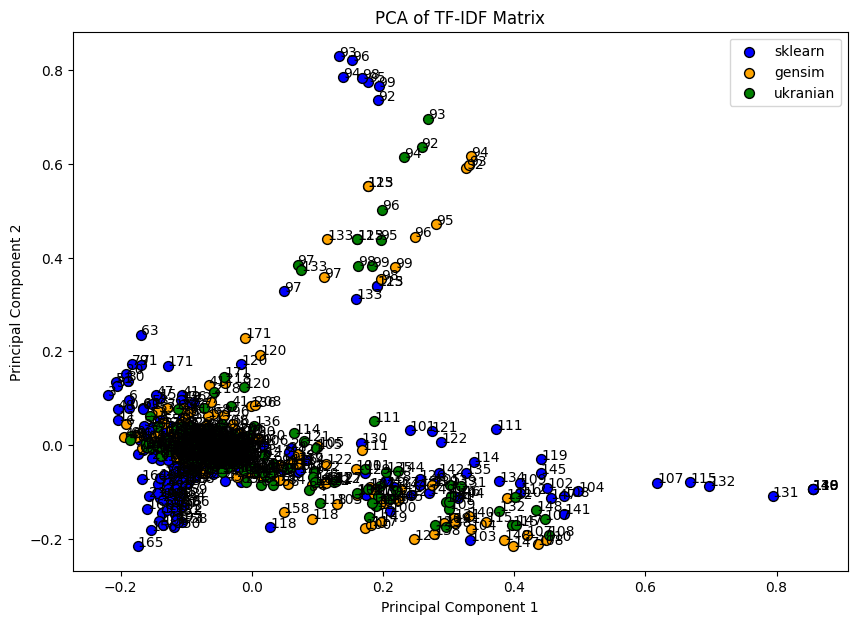

In [108]:
# Use sklearn TfidfVectorizer
plt.figure(figsize=(10, 7))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c='blue', edgecolor='k', s=50)
for i, txt in enumerate(doc_e):
    plt.annotate(i, (pca_result[i, 0], pca_result[i, 1]))


# Use spacy and gensim
plt.scatter(pca_result_g[:, 0], pca_result_g[:, 1], c='orange', edgecolor='k', s=50)
for i, txt in enumerate(doc_e):
    plt.annotate(i, (pca_result_g[i, 0], pca_result_g[i, 1]))

# Original Language
plt.scatter(pca_result_u[:, 0], pca_result_u[:, 1], c='green', edgecolor='k', s=50)
for i, txt in enumerate(doc_e):
    plt.annotate(i, (pca_result_u[i, 0], pca_result_u[i, 1]))

labels = ['sklearn', 'gensim', 'ukranian']
plt.legend(labels)
plt.title('PCA of TF-IDF Matrix')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.show()

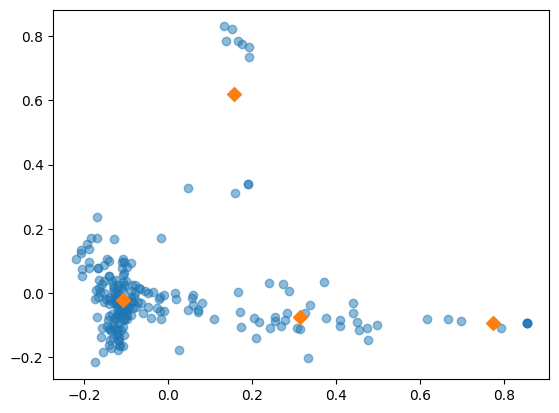

In [107]:
# KMeans clustering
from sklearn.cluster import KMeans

kmeans = KMeans(
    n_clusters=4,
    max_iter=100,
    n_init=5,
).fit(pca_result)

labels = kmeans.predict(pca_result)
# Make a scatter plot of xs and ys, using labels to define the colors
plt.scatter(pca_result[:, 0], pca_result[:,1],alpha=0.5)
# Assign the cluster centers: centroids
centroids = kmeans.cluster_centers_
# Assign the columns of centroids: centroids_x, centroids_y
centroids_x = centroids[:,0]
centroids_y = centroids[:,1]
# Make a scatter plot of centroids_x and centroids_y
plt.scatter(centroids_x,centroids_y,marker='D',s=50)
plt.show()

## Google Fact Check Tools API

In [ ]:
import requests
#https://developers.google.com/fact-check/tools/api/reference/rest/v1alpha1/claims/search
from google.colab import userdata

def fact_check_search(query, api_key):
  # Base URL for the API
  url = "https://factchecktools.googleapis.com/v1alpha1/claims:search"
  # Parameters for the API request
  params = {
    'query': query, # Search term (string)
    'languageCode': 'en', # Language (optional)
    'key': api_key, # Your API key
    'pageSize': 10 # Number of results returned,
    # 'maxAgeDays': 30 # Maximum age of the results in days
    }

  # Make the GET request
  response = requests.get(url, params=params)
  # Handle response
  if response.status_code == 200:
    return response.json()
  else:
    print(f"Error: {response.status_code}, {response.text}")
    return None

# Replace with your API key
API_KEY = userdata.get('fact_check_apikey')
search_query = "Ukraine"
result = fact_check_search(search_query, API_KEY)

# Print results
if result:
  for claim in result.get('claims', []):
    print(f"Claim: {claim.get('text')}")
    print(f"Claimant: {claim.get('claimant')}")
    print(f"Rating: {claim.get('claimReview', [{}])[0].get('textualRating')}")
    print(f"URL: {claim.get('claimReview', [{}])[0].get('url')}")
    print("-" * 40)


Claim: Trump & Netanyahu are Planning on Resettling Gazans in Ukraine or Syria
Claimant: Facebook,Twitter
Rating: False
URL: https://www.thequint.com/news/webqoof/trump-netanyahu-gaza-immigrants-ukraine-syria-misleading-post-fact-check
----------------------------------------
Claim: Ukrainian President Volodymyr Zelenskyy has acquired a 51 percent stake in Northam Platinum Ltd, a major South African mining company.
Claimant: X, Facebook, Instagram, Telegram, Threads, TikTok, Press 24, and AIF
Rating: Fake
URL: https://www.logicallyfacts.com/en/fact-check/sabc-news-did-not-report-that-zelenskyy-bought-stake-in-northam-platinum-mine
----------------------------------------
Claim: An image shows a BBC News graphic naming Ukraine's "next president"
Claimant: Multiple people
Rating: Altered picture
URL: https://factcheck.afp.com/doc.afp.com.42BV3CV
----------------------------------------
Claim: Netanyahu recently announced plans to resettle Palestinians in Gaza to Ukraine and Syria.
Claima

In [ ]:
# @title Alternative: Use an open-source Library to get access to Fact Check Tools
!pip install git+https://github.com/GONZOsint/factcheckexplorer.git

In [ ]:
import pandas as pd, numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## 1. Scraping Telegram

In [ ]:
! pip install pyrogram
! pip3 install -U tgcrypto

Discover Telegram Channels: https://tgstat.ru/en

Check out `pyrogram`: https://docs.pyrogram.org/

Get the Telegram API id and hash: https://core.telegram.org/api/obtaining_api_id

In [ ]:
from pyrogram import Client
from google.colab import userdata

api_id = int(userdata.get('api_id'))
api_hash = userdata.get('api_hash')

app = Client("UkraineRussiaCrisis", api_id=api_id, api_hash=api_hash)

In [ ]:
# Use the existing event loop in Jupyter/IPython
import nest_asyncio
import asyncio
import json
from pyrogram.types import Message

def get_reactions(message):
    reactions = {}
    if hasattr(message, "reactions") and message.reactions is not None:
        for reaction in message.reactions.reactions:
            reactions[reaction.emoji] = reaction.count
    return reactions

def get_urls(entities):
    urls = []
    if entities:
        for entity in entities:
            try:
                if entity.url is not None:
                    urls.append(entity.url)
            except:
                pass
    return urls

async def get_channel_history(chat_id, output_file=None, message_limit=15):
    output_file = chat_id if output_file is None else output_file

    if not app.is_connected:
        await app.start()

    chat = await app.get_chat(chat_id)
    followers_count = chat.members_count or 0

    all_messages, message_dicts = [], []
    async for message in app.get_chat_history(chat_id, limit=message_limit):

        all_messages.append(message)

        message_dict = {
            "id": message.id,
            "text": message.text,
            "date": message.date.isoformat(),
            "caption": message.caption,
            "views": message.views,
            "forwards": message.forwards,
            "reactions": get_reactions(message),
            "channel_memebers_count": followers_count,
            "channel_username": message.chat.username,
            "sender_username": message.sender_chat.username,
            "channel_id": message.chat.id,
            "sender_id": message.sender_chat.id,
            "channel_is_verified": message.chat.is_verified,
            "sender_is_verified": message.sender_chat.is_verified,
            "reply_to_message_id": message.reply_to_message_id,
            "reply_to_top_message_id": message.reply_to_top_message_id,
            "video": message.video.file_id if message.video else None,
            "photo": message.photo.file_id if message.photo else None,
            "sticker": message.sticker.file_id if message.sticker else None,
            "url": get_urls(message.caption_entities)

        }

        message_dicts.append(message_dict)

    with open(f'{output_file}.json', 'w', encoding='utf-8') as f:
        json.dump(message_dicts, f, ensure_ascii=False, indent=4)

    if app.is_connected:
        await app.stop()



In [ ]:
channels = pd.read_csv('/UkraineTGChannels.csv')
occupied = channels[channels['Category']=='Occupied'].Username.to_list()
deoccupied = channels[channels['Category']=='De-occupied'].Username.to_list()

In [ ]:
np.random.seed(42)

occupied_sample = np.random.choice(occupied, min(25, len(occupied)), replace=False)
deoccupied_sample = np.random.choice(deoccupied, min(25, len(deoccupied)),replace=False)

print(f"Sampled {len(occupied_sample)} occupied channels: {occupied_sample}")
print(f"Sampled {len(deoccupied_sample)} deoccupied channels: {deoccupied_sample}")

Sampled 25 occupied channels: ['sfr_lnr' 'tp_mrpl' 'novsevlisrub' 'zovsd' 'Lis_go_home'
 'Mariupoltrans2022' 'mariupol_0629_black' 'mtspdnr' 'hercon_ru' 'lhs1934'
 'pushilindenis' 'popovua' 'rabota_mel_rai' 'glava_lnr_info'
 'mitropol_crimea' 'Mariypolina_life' 'alexeytsydenov' 'searchforloved'
 'klever_flo_mrpl' 'mariupol_online24' 'trikotagmelio' 'dntormozok'
 'nm_dnr' 'luka_ebkov' 'Ukraina2022yors']
Sampled 25 deoccupied channels: ['koryukivka' 'hueviy_kherson' 'tipherson' 'VKhersone' 'city_ks'
 'dn_kherson' 'krkvka' 'mostks' 'susidycity' 'mdk_kherson'
 'partizanyofkrk' 'kherson_donbas' 'newskhersonlife' 'countryfreekherson'
 'jurnko' 'Koryukovka' 'zdrxerson' 'kavun_ks' 'kherson_uyut'
 'kherson_unbroken' 'fkherson' 'Koryukivka_MR' 'kherson_non_fake'
 'HersonVestnik' 'oleshkytop']


In [ ]:
nest_asyncio.apply()
await get_channel_history("rian_ru",message_limit=100)

Welcome to Pyrogram (version 2.0.106)
Pyrogram is free software and comes with ABSOLUTELY NO WARRANTY. Licensed
under the terms of the GNU Lesser General Public License v3.0 (LGPL-3.0).

Enter phone number or bot token: +4915208071188
Is "+4915208071188" correct? (y/N): y
The confirmation code has been sent via Telegram app
Enter confirmation code: 61800


In [ ]:
nest_asyncio.apply()
for chat_id in occupied_sample:
    try:
      await get_channel_history(chat_id,output_file=f'occupied/{chat_id}',message_limit=100)
    except Exception as e:
      print(f"Error processing channel {chat_id}: {e}")

for chat_id in deoccupied_sample:
    try:
      await get_channel_history(chat_id,output_file=f'deoccupied/{chat_id}',message_limit=100)
    except Exception as e:
      print(f"Error processing channel {chat_id}: {e}")

Error processing channel sfr_lnr: Client is already terminated
Error processing channel tp_mrpl: Telegram says: [400 USERNAME_NOT_OCCUPIED] - The username is not occupied by anyone (caused by "contacts.ResolveUsername")
Error processing channel novsevlisrub: Client is already terminated
Error processing channel zovsd: Client is already terminated
Error processing channel Lis_go_home: Telegram says: [400 USERNAME_NOT_OCCUPIED] - The username is not occupied by anyone (caused by "contacts.ResolveUsername")
Error processing channel Mariupoltrans2022: Client is already terminated
Error processing channel mariupol_0629_black: Client is already terminated
Error processing channel mtspdnr: Client is already terminated
Error processing channel hercon_ru: Client is already terminated
Error processing channel lhs1934: Client is already terminated
Error processing channel pushilindenis: Client is already terminated
Error processing channel popovua: Client is already terminated
Error processing ch

CancelledError: 

In [ ]:
import glob

def json_to_df(json_files):
    all_data = []
    for file in json_files:
        try:
            with open(file, 'r', encoding='utf-8') as f:
                data = json.load(f)
                all_data.extend(data)
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON in file {file}: {e}")

    if all_data:
      return pd.DataFrame(all_data)
    else:
      print("No data found in JSON files.")
      return None


In [ ]:
json_files = glob.glob("occupied/*.json")
oc_df = json_to_df(json_files)
json_files = glob.glob("deoccupied/*.json")
deoc_df = json_to_df(json_files)

In [ ]:
oc_df['category'] = 'occupied'
deoc_df['category'] = 'deoccupied'
df = pd.concat([oc_df, deoc_df], ignore_index=True)

In [ ]:
df

,id,text,date,caption,views,forwards,reactions,channel_memebers_count,channel_username,sender_username,...,sender_id,channel_is_verified,sender_is_verified,reply_to_message_id,reply_to_top_message_id,video,photo,sticker,url,category
0,211579,Lpr 1 (Telegram)\n\nМирный житель Горловки пос...,2025-04-10T19:57:46,None,9.0,0.0,{},529,lhs1934,lhs1934,...,-1001752006889,False,False,NaN,NaN,None,None,None,[],occupied
1,211578,Lpr 1 (Telegram)\n\nРСЧС: Внимание! На всей те...,2025-04-10T19:57:46,None,9.0,0.0,{},529,lhs1934,lhs1934,...,-1001752006889,False,False,NaN,NaN,None,None,None,[],occupied
2,211577,Lpr 1 (Telegram)\n\nВалуйки \nВнимание БПЛА в ...,2025-04-10T19:57:46,None,8.0,0.0,{},529,lhs1934,lhs1934,...,-1001752006889,False,False,NaN,NaN,None,None,None,[],occupied
3,211576,Lpr 1 (Telegram)\n\nЛазурное Ракетная опасност...,2025-04-10T19:57:46,None,7.0,0.0,{},529,lhs1934,lhs1934,...,-1001752006889,False,False,NaN,NaN,None,None,None,[],occupied
4,211575,"Lpr 1 (Telegram)\n\nКашарский р-он, Ростовской...",2025-04-10T19:57:46,None,8.0,0.0,{},529,lhs1934,lhs1934,...,-1001752006889,False,False,NaN,NaN,None,None,None,[],occupied
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4015,20351,None,2025-04-05T11:46:45,None,57991.0,254.0,{},113845,kherson_non_fake,kherson_non_fake,...,-1001658917464,False,False,20346.0,20345.0,None,AgACAgIAAx0CYuESWAACT39n-CTb0G_zxfDIgIAQ_m2ByY...,None,[],deoccupied
4016,20350,None,2025-04-05T11:46:45,❗️Кадры с последствиями ночных ударов рф по Дн...,55902.0,261.0,"{'💔': 677, '🤬': 587, '🙏': 142, '👍': 47, '😱': 1...",113845,kherson_non_fake,kherson_non_fake,...,-1001658917464,False,False,20346.0,20345.0,None,AgACAgIAAx0CYuESWAACT35n-CTbfLmbBqHr0sDSrWNDm4...,None,[],deoccupied
4017,20349,❗️На 13:30 ⏱️ артиллерия рф ведет артобстрел Д...,2025-04-05T10:32:58,None,62655.0,39.0,"{'🤬': 904, '🙏': 253, '👍': 26, '💔': 25, '😱': 12...",113845,kherson_non_fake,kherson_non_fake,...,-1001658917464,False,False,20347.0,NaN,None,None,None,[],deoccupied
4018,20348,❗️Также враг ведёт обстрел жилых кварталов в р...,2025-04-05T09:55:13,None,60139.0,55.0,"{'🤬': 898, '🙏': 216, '💔': 56, '👍': 28, '🤣': 9,...",113845,kherson_non_fake,kherson_non_fake,...,-1001658917464,False,False,20347.0,NaN,None,None,None,[],deoccupied


## 2. Text Analysis




In [ ]:
df[['text', 'caption']] = df[['text', 'caption']].fillna("")
df['all_text'] = df['caption'] + ' ' + df['text']
df = df[df['all_text'] != ' ']
df['all_text_prep'] = df['all_text'].apply(lambda x: x[:512] + '...' if len(x) > 512 else x)

<ipython-input-18-af110f64ef1c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['all_text_prep'] = df['all_text'].apply(lambda x: x[:512] + '...' if len(x) > 512 else x)


In [ ]:
n_samples = 250
dfsmall = df.groupby('category').apply(lambda x: x.sample(n=n_samples, random_state=42)).reset_index(drop=True)

<ipython-input-19-e834755253d6>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dfsmall = df.groupby('category').apply(lambda x: x.sample(n=n_samples, random_state=42)).reset_index(drop=True)


### 2.1 ChatGPT

Get openai api key: https://platform.openai.com/docs/overview

In [ ]:
%%capture
!pip install openai==1.55.3 httpx==0.27.2 --force-reinstall --quiet

In [ ]:
import openai
from openai import OpenAI

openai.api_key = userdata.get('openai_key')
client = OpenAI(api_key=userdata.get('openai_key'))

In [ ]:
def analyze_texts(texts):
    results = []
    for text in texts:
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {
                    "role": "system",
                    "content": (
                        "You are an assistant that analyzes Telegram posts for specific linguistic categories. "
                        "For each input text, return a JSON object with the following keys: "
                        "'discrediting', 'emotion', 'polarization', 'impersonation', 'conspiracy', 'trolling', "
                        "'pro-ukrainian', 'pro-russian'."
                        "Each key should have a value between 0 and 6 indicating the intensity of the category."
                        "Discrediting refers to discrediting opponents or creating doubt about them."
                        "Emotion refers to the use of outrage or highly emotive language to manipulate people."
                        "Polarization here means using divisive issues to drive a wedge between two groups."
                        "Impersonation refers to misusing the identity of politicians, experts, or celebrities."
                        "Conspiracy refers to casting doubt on mainstream narratives by providing an attractive story in which a small sinister group of people is responsible for doing harm to many."
                        "Trolling is aimed at eliciting reactions from people by provoking them."
                        "Finally, rate if the post has a pro-Ukrainian or a pro-Russian view on the war in Ukraine."
                    ),
                },
                {"role": "user", "content": f"Analyze this post: {text}"},
            ],
            temperature=0.0,
            response_format = { "type": "json_object" },
        )
        results.append(response.choices[0].message.content)
    return results

In [ ]:
# 500 posts took around 16 minutes
results = analyze_texts(dfsmall.all_text_prep)
results_df = pd.DataFrame([json.loads(result) for result in results])

In [ ]:
results_df_all = pd.concat([dfsmall, results_df], axis=1)

NameError: name 'results_df' is not defined

In [ ]:
for i, row in results_df_all[:10].iterrows():
    print(f"Category: {row['category']}")
    print(f"Post: {row['all_text']}")
    print(f"Discrediting: {row['discrediting']}")
    print(f"Emotion: {row['emotion']}")
    print(f"Polarization: {row['polarization']}")
    print(f"Impersonation: {row['impersonation']}")
    print(f"Conspiracy: {row['conspiracy']}")
    print(f"Trolling: {row['trolling']}")
    print(f"Pro-Ukrainian: {row['pro-ukrainian']}")
    print(f"Pro-Russian: {row['pro-russian']}")
    print()


Category: deoccupied
Post: 💡❗Графіки відключень світла по Чернігівщині на 15 грудня

У неділю, 15 грудня по країні будуть відключення електроенергії. Графіки обмеження для населення діятимуть із 08:00 до 22:00, для бізнесу -  також із 08:00 до 22:00. Задіють від однієї до двох черг відключень електроенергії. 
Discrediting: 0
Emotion: 0
Polarization: 0
Impersonation: 0
Conspiracy: 0
Trolling: 0
Pro-Ukrainian: 0
Pro-Russian: 0

Category: deoccupied
Post:  💔 С 1 января госпошлина на развод вырастет в 8 раз 

Прежняя цена за расторжение брака 650₽, новая — 5000₽.
Discrediting: 0
Emotion: 1
Polarization: 0
Impersonation: 0
Conspiracy: 0
Trolling: 0
Pro-Ukrainian: 0
Pro-Russian: 0

Category: deoccupied
Post:  ❤️ Взятие Бердина - вброс гребней и паникеров.
Противник даже к н.п. не подошёл, умирает на подходах, в посадках.
Идут ожесточенные бои.
Те, кто сдают город в инфополе - к расстрелу.
@iamsniper

ИзХерсонец - http://t.me/Kherson_Uyut
Прислать сообщение в бот
Discrediting: 4
Emotion: 3
Po

### 2.2 Open source models

In [ ]:
results_df_all = pd.read_csv('results_df_all_custom.csv')

In [ ]:
! pip install 'transformers[torch]'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 57.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
from transformers import pipeline
import torch

classifier = pipeline("zero-shot-classification",
                      model="MoritzLaurer/mDeBERTa-v3-base-mnli-xnli",
                      device=0 if torch.cuda.is_available() else -1)
sequence_to_classify = "Русня - не люди."
candidate_labels = ["pro-russian",'pro-ukrainian']
output = classifier(sequence_to_classify, candidate_labels, multi_label=False)
print(output)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.07k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.26k [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/16.3M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

Device set to use cuda:0


{'sequence': 'Русня - не люди.', 'labels': ['pro-ukrainian', 'pro-russian'], 'scores': [0.6381645798683167, 0.36183542013168335]}


In [ ]:
sequence_to_classify = "Русня - не люди."
candidate_labels = ["solidarity with Ukraine or Ukrainians",'other']
output = classifier(sequence_to_classify, candidate_labels, multi_label=False)
print(output)

{'sequence': 'Русня - не люди.', 'labels': ['other', 'solidarity with Ukraine or Ukrainians'], 'scores': [0.953911542892456, 0.04608844965696335]}


In [ ]:
sequence_to_classify = "Русня - не люди."
candidate_labels = ["hostility towards Russia or Russians",'other']
output = classifier(sequence_to_classify, candidate_labels, multi_label=False)
print(output)

{'sequence': 'Русня - не люди.', 'labels': ['hostility towards Russia or Russians', 'other'], 'scores': [0.5148583650588989, 0.48514166474342346]}


In [ ]:
candidate_labels = ["pro-russian",'pro-ukrainian']
output = classifier(list(results_df_all['all_text_prep'].values), candidate_labels, multi_label=False)
print(output)

[{'sequence': '💡❗Графіки відключень світла по Чернігівщині на 15 грудня\n\nУ неділю, 15 грудня по країні будуть\xa0відключення\xa0електроенергії. Графіки обмеження для населення діятимуть із 08:00 до 22:00, для бізнесу - \xa0також із 08:00 до 22:00.\xa0Задіють від однієї до двох черг відключень електроенергії. ', 'labels': ['pro-ukrainian', 'pro-russian'], 'scores': [0.5116892457008362, 0.4883107542991638]}, {'sequence': ' 💔 С 1 января госпошлина на развод вырастет в 8 раз \n\nПрежняя цена за расторжение брака 650₽, новая — 5000₽.', 'labels': ['pro-russian', 'pro-ukrainian'], 'scores': [0.544937789440155, 0.4550621807575226]}, {'sequence': ' ❤️ Взятие Бердина - вброс гребней и паникеров.\nПротивник даже к н.п. не подошёл, умирает на подходах, в посадках.\nИдут ожесточенные бои.\nТе, кто сдают город в инфополе - к расстрелу.\n@iamsniper\n\nИзХерсонец - http://t.me/Kherson_Uyut\nПрислать сообщение в бот', 'labels': ['pro-ukrainian', 'pro-russian'], 'scores': [0.6389063000679016, 0.361093

In [ ]:
results2 = pd.DataFrame([
    {
        **{label: score for label, score in zip(item['labels'], item['scores'])}
    }
    for item in output
])

In [ ]:
results2

,pro-ukrainian,pro-russian
0,0.511689,0.488311
1,0.455062,0.544938
2,0.638906,0.361094
3,0.477264,0.522736
4,0.643907,0.356093
...,...,...
495,0.588331,0.411669
496,0.477560,0.522440
497,0.423041,0.576959
498,0.553514,0.446486


In [ ]:
results2.columns = ['pro-ukrainian-mDeBERTa','pro-russian-mDeBERTa']

### 2.3 Custom models

Fine-tuning a language model: https://huggingface.co/docs/transformers/en/training

Ukraine POV model: https://huggingface.co/YaraKyrychenko/ukraine-war-pov

In [ ]:
custom_classifier = pipeline("text-classification",
                             model='YaraKyrychenko/ukraine-war-pov',
                             device=0 if torch.cuda.is_available() else -1)

config.json:   0%|          | 0.00/902 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/279 [00:00<?, ?B/s]

Device set to use cpu


In [ ]:
custom_output = custom_classifier(list(results_df_all['all_text_prep'].values),return_all_scores=True)
print(custom_output)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


[[{'label': 'proukrainian', 'score': 0.995915949344635}, {'label': 'prorussian', 'score': 0.004084078595042229}], [{'label': 'proukrainian', 'score': 0.007027463521808386}, {'label': 'prorussian', 'score': 0.9929724931716919}], [{'label': 'proukrainian', 'score': 0.006853173486888409}, {'label': 'prorussian', 'score': 0.9931468367576599}], [{'label': 'proukrainian', 'score': 0.9957699179649353}, {'label': 'prorussian', 'score': 0.004230044782161713}], [{'label': 'proukrainian', 'score': 0.9958264231681824}, {'label': 'prorussian', 'score': 0.00417356239631772}], [{'label': 'proukrainian', 'score': 0.9954093098640442}, {'label': 'prorussian', 'score': 0.004590619821101427}], [{'label': 'proukrainian', 'score': 0.8309731483459473}, {'label': 'prorussian', 'score': 0.1690269112586975}], [{'label': 'proukrainian', 'score': 0.006775944493710995}, {'label': 'prorussian', 'score': 0.993224024772644}], [{'label': 'proukrainian', 'score': 0.22608648240566254}, {'label': 'prorussian', 'score': 0

In [ ]:
results_custom = pd.DataFrame([
    {item['label']: item['score'] for item in row}
    for row in custom_output
])

In [ ]:
results_custom

,proukrainian,prorussian
0,0.995916,0.004084
1,0.007027,0.992972
2,0.006853,0.993147
3,0.995770,0.004230
4,0.995826,0.004174
...,...,...
495,0.007292,0.992708
496,0.006721,0.993279
497,0.006717,0.993283
498,0.223717,0.776283


In [ ]:
results_custom.columns = ['pro-ukrainian-custom','pro-russian-custom']

In [ ]:
results_df_all = pd.concat([results_df_all, results2,results_custom], axis=1)

### 2.4 Comparison

In [ ]:
results_df_all['ur'] = results_df_all['pro-ukrainian'] - results_df_all['pro-russian']
results_df_all['ua_bin'] = results_df_all['ur'].apply(lambda x: 1 if x > 3 else 0)
results_df_all['ru_bin'] = results_df_all['ur'].apply(lambda x: 1 if x < -3 else 0)
pd.crosstab(results_df_all['ua_bin'], results_df_all['ru_bin'])

results_df_all['ur_mDeBERTa'] = results_df_all['pro-ukrainian-mDeBERTa'] - results_df_all['pro-russian-mDeBERTa']
results_df_all['ua_mDeBERTa'] = results_df_all['ur_mDeBERTa'].apply(lambda x: 1 if x > 0.15 else 0)
results_df_all['ru_mDeBERTa'] = results_df_all['ur_mDeBERTa'].apply(lambda x: 1 if x < -0.15 else 0)

In [ ]:

results_df_all['ur_custom'] = results_df_all['pro-ukrainian-custom'] - results_df_all['pro-russian-custom']
results_df_all['ua_custom'] = results_df_all['ur_custom'].apply(lambda x: 1 if x > 0.95 else 0)
results_df_all['ru_custom'] = results_df_all['ur_custom'].apply(lambda x: 1 if x < -0.95 else 0)

In [ ]:
pd.crosstab(results_df_all['ua_mDeBERTa'], results_df_all['ru_mDeBERTa'])

ru_mDeBERTa,0,1
ua_mDeBERTa,,
0,427,40
1,33,0


In [ ]:
pd.crosstab(results_df_all['ua_custom'], results_df_all['ru_custom'])

ru_custom,0,1
ua_custom,,
0,95,238
1,167,0


Column: ua_mDeBERTa
Accuracy: 0.872
F1 Score: 0.544315333789018


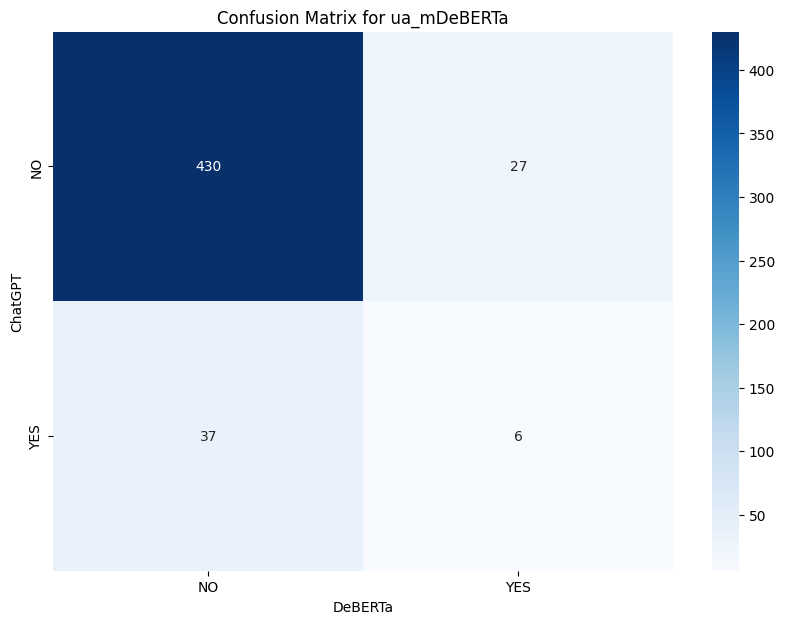

Column: ru_mDeBERTa
Accuracy: 0.82
F1 Score: 0.54753861003861


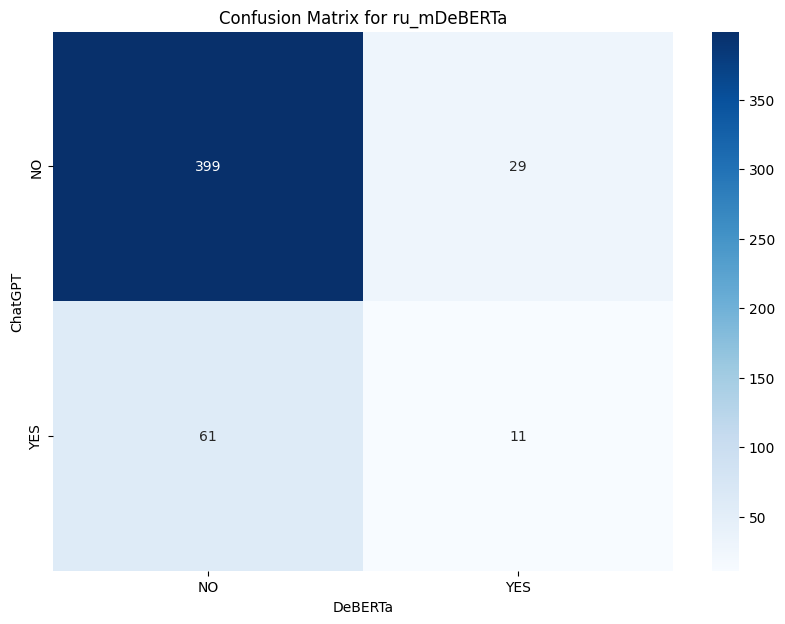

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

columns = ['ua_mDeBERTa','ru_mDeBERTa']
corr_dict = {
    'ua_mDeBERTa':'ua_bin',
    'ru_mDeBERTa':'ru_bin'
}

for column in columns:
    conf_matrix = confusion_matrix(results_df_all[corr_dict[column]], results_df_all[column])
    accuracy = accuracy_score(results_df_all[corr_dict[column]], results_df_all[column])
    f1 = f1_score(results_df_all[corr_dict[column]], results_df_all[column], average='macro')

    print(f'Column: {column}')
    print(f'Accuracy: {accuracy}')
    print(f'F1 Score: {f1}')

    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['NO', 'YES'], yticklabels=['NO', 'YES'])
    plt.xlabel('DeBERTa')
    plt.ylabel('ChatGPT')
    plt.title(f'Confusion Matrix for {column}')
    plt.show()

Column: ua_custom
Accuracy: 0.748
F1 Score: 0.620253164556962


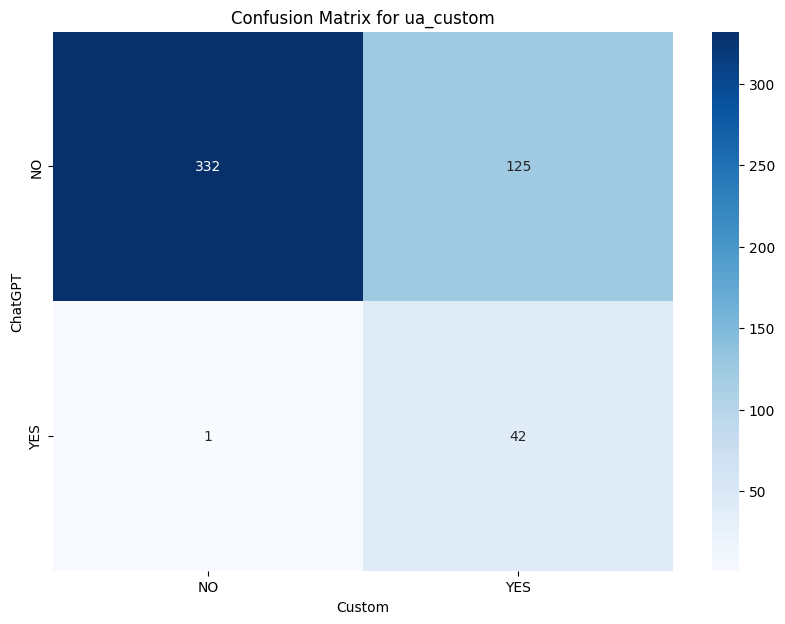

Column: ru_custom
Accuracy: 0.648
F1 Score: 0.5885928003740065


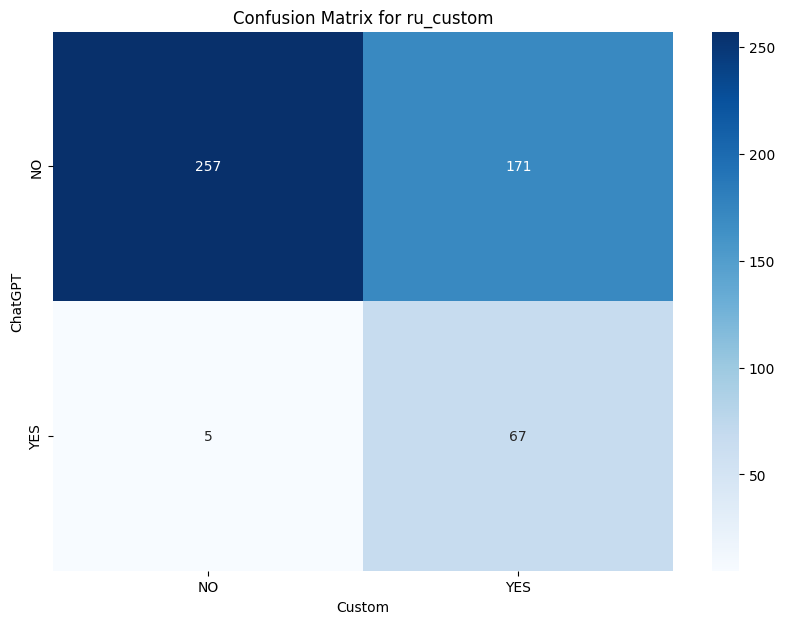

In [ ]:
columns = ['ua_custom','ru_custom']
corr_dict = {
    'ua_custom':'ua_bin',
    'ru_custom':'ru_bin'
}

for column in columns:
    conf_matrix = confusion_matrix(results_df_all[corr_dict[column]], results_df_all[column])
    accuracy = accuracy_score(results_df_all[corr_dict[column]], results_df_all[column])
    f1 = f1_score(results_df_all[corr_dict[column]], results_df_all[column], average='macro')

    print(f'Column: {column}')
    print(f'Accuracy: {accuracy}')
    print(f'F1 Score: {f1}')

    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['NO', 'YES'], yticklabels=['NO', 'YES'])
    plt.xlabel('Custom')
    plt.ylabel('ChatGPT')
    plt.title(f'Confusion Matrix for {column}')
    plt.show()

## 3. Statistics





Hypotheses testing, e.g.:
- H1: Emotional content has an effect on forwards.
- H0: Emotional content has no effect on forwards.

Or:
- H1: Pro-Ukrainian/Pro-Russian content will get more forwards in deoccupied/occupied channels. (IE The interaction between content type and channel type has an effect on forwards.)

We want to control for how many people viewed the message, for instance, and other linguistic categories.

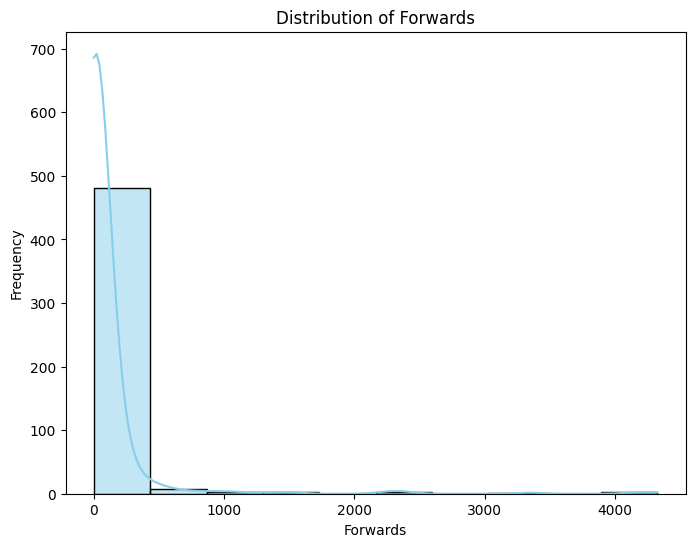

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(results_df_all['forwards'], kde=True, bins=10, color='skyblue')
plt.title('Distribution of Forwards')
plt.xlabel('Forwards')
plt.ylabel('Frequency')
plt.show()

In [ ]:
print(f"Mean of forwards: {results_df_all['forwards'].mean()}")
print(f"Standard deviation of forwards: {results_df_all['forwards'].std()}")

Mean of forwards: 89.324
Standard deviation of forwards: 380.02828054241445


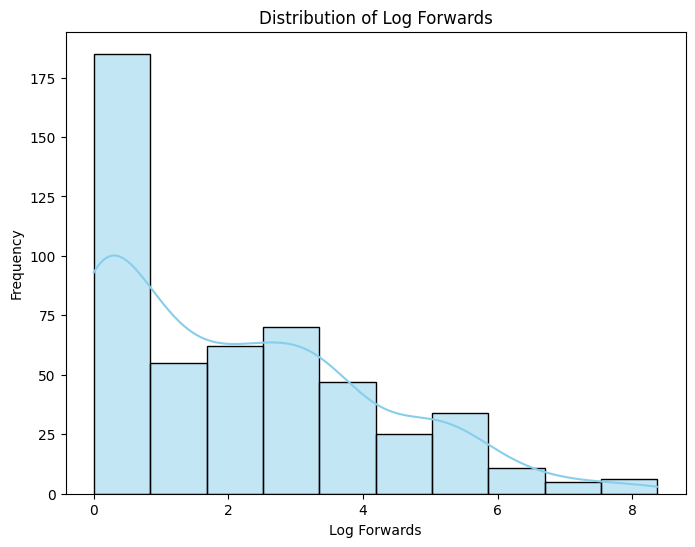

In [ ]:
results_df_all['log_forwards'] = np.log(1 + results_df_all['forwards'])
plt.figure(figsize=(8, 6))
sns.histplot(results_df_all['log_forwards'], kde=True, bins=10, color='skyblue')
plt.title('Distribution of Log Forwards')
plt.xlabel('Log Forwards')
plt.ylabel('Frequency')
plt.show()

We could try using [negative binomial regression](https://en.wikipedia.org/wiki/Poisson_regression), which is good for overdispersed count data.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
results_df_all['views_scaled'] = scaler.fit_transform(results_df_all[['views']])

results_df_all['occupied'] = results_df_all['category'].apply(lambda x: 1 if x == 'occupied' else 0)
results_df_all["pro-ru in occupied"] = results_df_all['pro-russian']*results_df_all['occupied']
results_df_all["pro-ua in occupied"] = results_df_all['pro-ukrainian']*results_df_all['occupied']

In [ ]:
# dependent variable
dv = 'forwards'

# independent variables
predictors = ['pro-ukrainian', 'pro-russian',
              'views_scaled', # control variable
              'discrediting', 'emotion', 'polarization',
              'impersonation', 'conspiracy', 'trolling']

In [ ]:
import statsmodels.api as sm

X = results_df_all[['occupied','pro-ru in occupied',"pro-ua in occupied"]+predictors]
X = sm.add_constant(X)           # Add constant for the intercept
y = results_df_all[dv]

model = sm.GLM(y, X, family=sm.families.NegativeBinomial()).fit()

print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               forwards   No. Observations:                  500
Model:                            GLM   Df Residuals:                      487
Model Family:        NegativeBinomial   Df Model:                           12
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2063.3
Date:                Mon, 13 Jan 2025   Deviance:                       1290.0
Time:                        14:08:51   Pearson chi2:                 1.52e+03
No. Iterations:                    56   Pseudo R-squ. (CS):             0.9356
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.0039      0

/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


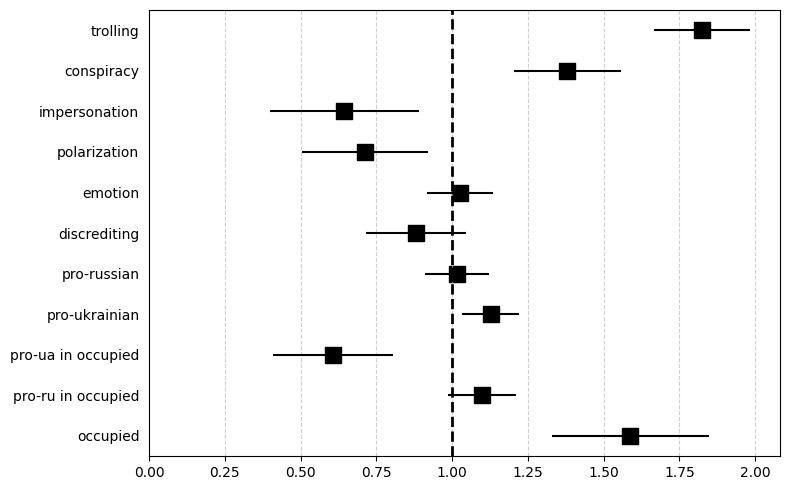

In [ ]:
def dw_plot(model):
    err_series = model.params - model.conf_int()[0]
    coef_df = pd.DataFrame({'coef': np.exp(model.params.values[1:]),
                        'err': err_series.values[1:],
                        'varname': err_series.index.values[1:]
                       })
    coef_df = coef_df[coef_df['varname'] != 'views_scaled']
    fig, ax = plt.subplots(figsize=(8, 5))


    coef_df.plot(x='varname', y='coef', kind='barh',
             ax=ax, color='none',
             xerr='err', legend=False, linewidth=1.5)


    ax.scatter(coef_df['coef'], np.arange(coef_df.shape[0]),
           marker='s', s=120, color='black')


    ax.axvline(x=1, linestyle='--', color='black', linewidth=2)


    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.yaxis.set_ticks_position('none')

    plt.tight_layout()

    ax.grid(True, axis='x', linestyle='--', alpha=0.6)

    plt.show()

dw_plot(model)

For a unit increase in trolling, the expected forwards rate increases by around exp(0.6013) - 1 = 82.45%.

Occupied

In [ ]:
X = results_df_all[results_df_all['occupied']==1][predictors]
X = sm.add_constant(X)
y = results_df_all[results_df_all['occupied']==1][dv]

model = sm.GLM(y, X, family=sm.families.NegativeBinomial()).fit()

print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               forwards   No. Observations:                  250
Model:                            GLM   Df Residuals:                      240
Model Family:        NegativeBinomial   Df Model:                            9
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1161.9
Date:                Mon, 13 Jan 2025   Deviance:                       653.62
Time:                        14:13:17   Pearson chi2:                     686.
No. Iterations:                    52   Pseudo R-squ. (CS):             0.9371
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             2.8348      0.114     24.781

/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


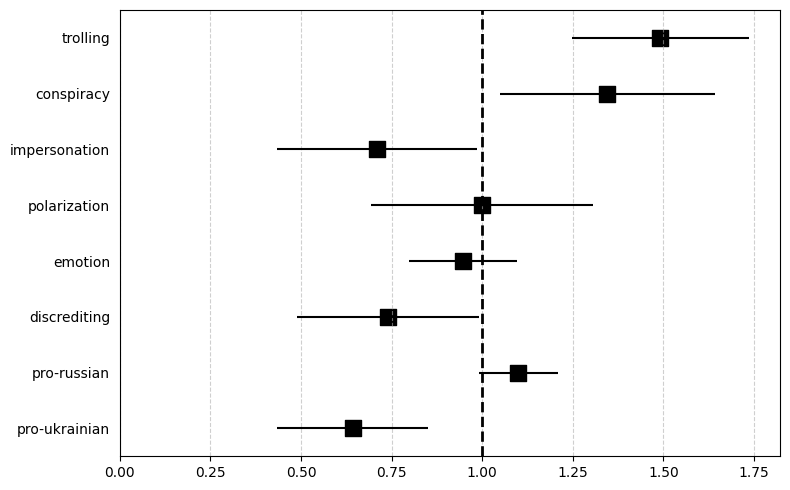

In [ ]:
dw_plot(model)

In [ ]:
X = results_df_all[results_df_all['occupied']==0][predictors]
X = sm.add_constant(X)
y = results_df_all[results_df_all['occupied']==0][dv]

model = sm.GLM(y, X, family=sm.families.NegativeBinomial()).fit()

print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               forwards   No. Observations:                  250
Model:                            GLM   Df Residuals:                      240
Model Family:        NegativeBinomial   Df Model:                            9
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -789.61
Date:                Mon, 13 Jan 2025   Deviance:                       412.72
Time:                        14:13:40   Pearson chi2:                     582.
No. Iterations:                    16   Pseudo R-squ. (CS):             0.8947
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.9716      0.136      7.119

/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


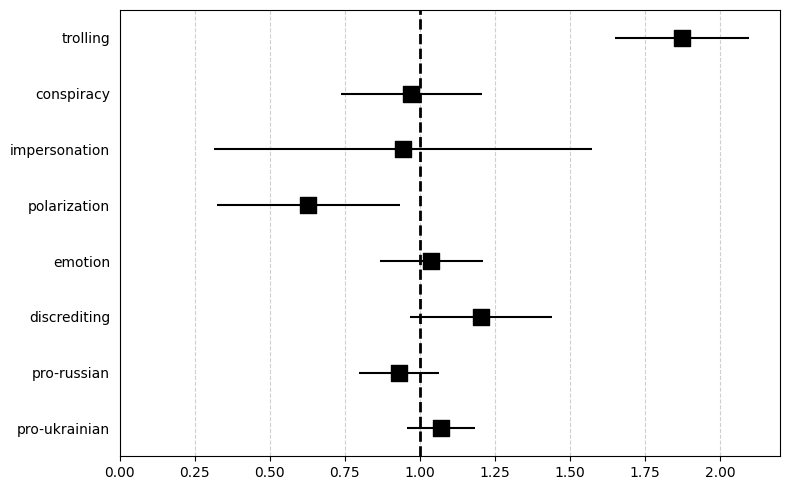

In [ ]:
dw_plot(model)